In [1]:
import pandas as pd
import re
import math
import time
import random
import matplotlib.pyplot as plt
import numpy as np

from deap import algorithms, base, creator, tools

In [2]:
# TSPLIB file reader
def read_tsplib_file(filename):
    if filename is None:
        raise FileNotFoundError('Filename can not be None')
    with open(filename) as file:
        lines = file.readlines()
        data = [line.lstrip() for line in lines if line != ""]
        dimension = re.compile(r'[^\d]+')
        for item in data:
            if item.startswith('DIMENSION'):
                dimension = int(dimension.sub('', item))
                break
        c = [-1.0] * (2 * dimension)
        cities_coord = []
        for item in data:
            if item[0].isdigit():
                j, coordX, coordY = [float(x.strip()) for x in item.split(' ')]
                c[2 * (int(j) - 1)] = coordX
                c[2 * (int(j) - 1) + 1] = coordY
                cities_coord.append([coordX, coordY])
        cities = pd.DataFrame(cities_coord)
        #         cities = cities_coord
        matrix = [[-1] * dimension for _ in range(dimension)]
        for k in range(dimension):
            matrix[k][k] = 0
            for j in range(k + 1, dimension):
                dist = math.sqrt((c[k * 2] - c[j * 2]) ** 2 + (c[k * 2 + 1] - c[j * 2 + 1]) ** 2)
                dist = round(dist)
                matrix[k][j] = dist
                matrix[j][k] = dist
        return matrix, dimension, cities

In [3]:
def evalTSP(individual):
    distance = dist_matrix[individual[-1]][individual[0]]
    for gene1, gene2 in zip(individual[0:-1], individual[1:]):
        distance += dist_matrix[gene1][gene2]
    return distance,

In [4]:
def create_clusters(X):
    from sklearn.cluster import KMeans
    clusters = 14
    km = KMeans(
        n_clusters=clusters, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    y_km = km.fit_predict(X)
    return y_km

In [5]:
def create_individual(k):
    ind = np.zeros(k.shape, dtype=np.int32)
    citylist = np.array(range(0, nb_cities))
    insertat = 0
    for i in range(np.unique(k).shape[0]):
        permut = np.random.permutation(citylist[k == i])
        for j in range(0, citylist[k == i].shape[0]):
            ind[insertat + j] = permut[j]
        insertat += permut.shape[0]
    return ind

In [12]:
def create_toolbox(num_cities, ind_mutpb, tourn_size):
    tb = base.Toolbox()

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, typecode='i', fitness=creator.FitnessMin)
    
#     tb.register("indices", np.random.permutation, num_cities)
    y_km = create_clusters(cities_coord)
    tb.register("indices", create_individual, y_km)
    
    tb.register("individual", tools.initIterate, creator.Individual, tb.indices)
    tb.register("population", tools.initRepeat, list, tb.individual)

    tb.register("mate", tools.cxOrdered)
    tb.register("mutate", tools.mutShuffleIndexes, indpb=ind_mutpb) 
    tb.register("select", tools.selTournament, tournsize=tourn_size) 
    tb.register("evaluate", evalTSP)
    return tb

In [7]:
def create_stats():
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register('min', np.min)
    return stats

In [8]:
# function to make print report of function solving

def print_solution(res, log, duration):
    
#     solution_x = tools.selBest(res, k=1)[0]
    solution_x = res[0]
    fitness = evalTSP(solution_x)[0]
    n_evals = sum([x['nevals'] for x in log])
    nb_gen = len(log)-1
    
    print("Function: %s" % problem_name)
    print("Problem dimension: %d" % nb_cities)
    print("Global Optimum: %d\n" % optimal_fitness)
    print("Algorithm: %s" % algorithm_name)
    print("Parameters:")
    for p in params:
        print("\t%s: " % p ,params[p] )
    
    print("\nFitness: %d" % fitness)
    print("Solution: ")
    print(solution_x)
    print("\nNb of functions evaluations: %d" % n_evals)
    print("Stopping criterion: after %d generations" % nb_gen)
    print("computational time: %.3f seconds" % duration)

    plt.plot(log.select('min'), 'c-')
    plt.ylabel('Fitness');
    plt.xlabel('Generations');
    plt.show()

In [9]:
# define algorithm parameters

algorithm_name = "Simple Evolutionary Algorithm"

pop_size = 500
nb_generations = 500
cross_prob = 0.85        # crossover probability

mut_prob = 0.08          # probability for route to mutate
indep_mut_prob = 1/194    # independent probability for each city to mutate

tournament_size = 4      # number of routes participating each tournament

params = {"Population Size": pop_size, 
          "Nb of generations": nb_generations,
          "Crossover probability": cross_prob, 
          "Mutation Probability": mut_prob, 
          "Indep. gene mut prob": indep_mut_prob,
          "Tournament size": tournament_size
         }


In [14]:
# instantiate problem to solve

problem_name = 'Qatar 194 TSP'
optimal_fitness = 9352
dist_matrix, nb_cities, cities_coord = read_tsplib_file('./qa194.tsp')

toolbox = create_toolbox(nb_cities, ind_mutpb = 1 / nb_cities, tourn_size=tournament_size)
fit_stats = create_stats()
hof = tools.HallOfFame(1)

/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [15]:
# run algorithm and print solution

random.seed(169)

t1 = time.time()
result, log = algorithms.eaSimple(toolbox.population(n=pop_size), 
                                  toolbox, 
                                  cxpb=cross_prob, 
                                  mutpb=mut_prob, 
                                  ngen=nb_generations, 
                                  verbose=False, 
                                  stats=fit_stats,
                                  halloffame=hof)
t2 = time.time()
# print_solution(res=result, log=log, duration=t2-t1)

Function: Qatar 194 TSP
Problem dimension: 194
Global Optimum: 9352

Algorithm: Simple Evolutionary Algorithm
Parameters:
	Population Size:  500
	Nb of generations:  500
	Crossover probability:  0.85
	Mutation Probability:  0.08
	Indep. gene mut prob:  0.005154639175257732
	Tournament size:  4

Fitness: 14663
Solution: 
[138, 145, 139, 131, 133, 125, 124, 126, 129, 141, 136, 155, 144, 148, 150, 154, 135, 130, 159, 184, 171, 175, 181, 193, 189, 186, 185, 182, 174, 172, 173, 178, 168, 160, 162, 163, 117, 114, 111, 109, 107, 106, 104, 105, 102, 92, 94, 91, 96, 95, 80, 78, 83, 72, 42, 51, 52, 55, 60, 65, 67, 63, 56, 44, 38, 37, 47, 45, 34, 29, 31, 30, 41, 49, 48, 43, 53, 54, 40, 39, 33, 26, 21, 28, 27, 20, 32, 17, 36, 46, 50, 57, 66, 101, 121, 146, 157, 161, 165, 179, 192, 191, 190, 188, 187, 167, 164, 176, 180, 183, 177, 169, 170, 166, 158, 147, 142, 134, 128, 132, 120, 119, 127, 122, 123, 116, 115, 99, 69, 59, 13, 6, 2, 3, 1, 0, 5, 7, 58, 61, 35, 84, 85, 64, 19, 62, 110, 93, 88, 89, 100,

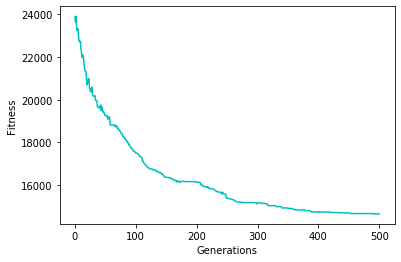

In [16]:
# print_solution(res=result, log=log, duration=t2-t1)
print_solution(res=hof, log=log, duration=t2-t1)

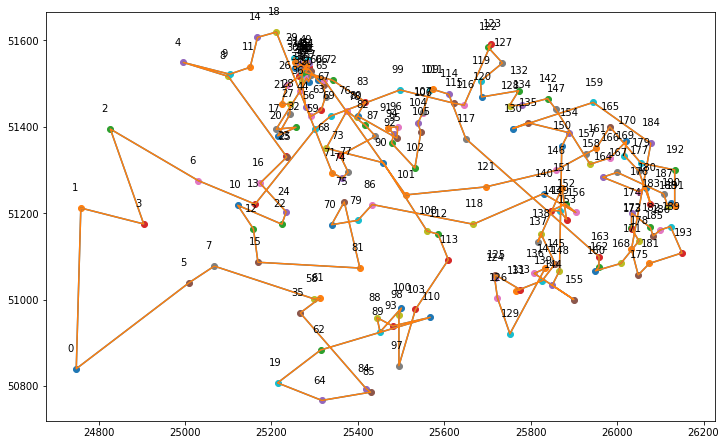

In [17]:
# display found solution

best_individual = tools.selBest(result, k=1)[0]

xlist = [cities_coord.iloc[i,0] for i in best_individual]
ylist = [cities_coord.iloc[i,1] for i in best_individual]

xlist.append(xlist[0])
ylist.append(ylist[0])

plt.figure(figsize=(12,12))
for idx,city in enumerate(cities_coord.values):
    plt.scatter(city[0],city[1])
    plt.text(city[0]-20, city[1]+40, str(idx), fontsize=10)

plt.plot(xlist, ylist, linestyle='-')
plt.plot(xlist, ylist, linestyle='-')
plt.axis('scaled')
plt.show()